In [5]:
import numpy as np

import seaborn as sns
import pandas as pd
import os

os.chdir(os.path.expanduser('~/PycharmProjects/vivarium-ecoli'))

import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult


sns.set(style='darkgrid', palette='viridis', context='talk')


# Import simulation output

Before running this, run a sim in ecoli/experiments/metabolism_redux_sim.py with -n 2 to generate a simulation output. This is necessary to replicate the simulation environment. Use the default .json config.

In [7]:
time = '10'
date = '2023-04-11'
experiment = 'fba-redux-standard'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [8]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [9]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [10]:
stoichiometry = agent['ecoli-metabolism'].model.stoichiometry
maintenance_reaction = agent['ecoli-metabolism'].model.maintenance_reaction
stoichiometry["maintenance_reaction"] = maintenance_reaction

bad_rxns = ["RXN-12440", "TRANS-RXN-121", "TRANS-RXN-300", "TRANS-RXN-8"] # generate carbon mistake in parca, efflux/influx proton gen, iron cheating
for rxn in bad_rxns:
    stoichiometry.pop(rxn, None)


Pandas automatically understands dicts of dicts as matrices.

In [11]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"])
sim_fluxes = pd.DataFrame(sim_fluxes.loc[4, :].abs().sort_values(ascending=False))
sim_fluxes.head(10)

,4
TRANS-RXN-300,14827025
TRANS-RXN-121,14827025
TRANS-RXN-145,4684766
ATPSYN-RXN (reverse),3620830
ASPAMINOTRANS-RXN,454019
GAPOXNPHOSPHN-RXN,430315
PHOSGLYPHOS-RXN (reverse),430313
2PGADEHYDRAT-RXN,429258
3PGAREARR-RXN (reverse),429210
FUMHYDR-RXN,360653


# Test changing nutrient composition

In [12]:
uptake = (fba["unconstrained_molecules"][3]).copy()
uptake_c = fba["constrained_molecules"]

uptake.extend(list(uptake_c.keys()))
uptake = set(uptake)

# addition = set(["CPD0-1074[c]"])
addition = set([
        "FRU[p]",
        # "NITRATE[p]"
        # 'THIAMINE[p]',
        # 'HYDROGEN-MOLECULE[p]',
        # 'FUM[p]'
])
removals = set([
                  "GLC[p]",
               #      # 'AMMONIUM[c]',
               #      # 'WATER[p]'
               #       # 'Pi[p]',
               #       # 'SULFATE[p]'
               # 'OXYGEN-MOLECULE[p]'
])


uptake = uptake | addition
uptake = uptake - removals
uptake

{'AMMONIUM[c]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CL-[p]',
 'CO+2[p]',
 'FE+2[p]',
 'FRU[p]',
 'K+[p]',
 'L-SELENOCYSTEINE[c]',
 'MG+2[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'OXYGEN-MOLECULE[p]',
 'Pi[p]',
 'SULFATE[p]',
 'WATER[p]',
 'ZN+2[p]'}

# Use NetworkFlowModel class to run model

In [13]:
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"]).loc[4, :]
exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"]).loc[4, :]
maintenance = pd.DataFrame(fba["target_maintenance_flux"]).at[4, 0]
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"]).loc[4, :]
homeostatic

2-3-DIHYDROXYBENZOATE[c]          73
2-KETOGLUTARATE[c]               187
2-PG[c]                           49
2K-4CH3-PENTANOATE[c]             72
4-AMINO-BUTYRATE[c]              161
                              ...   
WATER[c]                    22086088
XYLULOSE-5-PHOSPHATE[c]           89
ZN+2[c]                           89
ZN+2[p]                           53
glycogen-monomer[c]            35110
Name: 4, Length: 172, dtype: int64

In [14]:
model = NetworkFlowModel(reactions=stoichiometry, homeostatic_metabolites=list(dict(homeostatic).keys()))

In [15]:
model.set_up_exchanges(exchanges=list(dict(exchanges).keys()), uptakes=uptake)

In [16]:
solution: FlowResult = model.solve(homeostatic_targets=dict(homeostatic),
                                   maintenance_target=maintenance,
                                   kinetic_targets=dict(kinetic),
                                   binary_kinetic_targets={},
                                   objective_weights={'secretion': 0.001, 'efficiency': 0.00001, 'kinetics': 0.000001},
                                   upper_flux_bound=100000000)

In [17]:
pd.Series(solution.exchanges).sort_values(ascending=False).head(10)

WATER[p]              1.747716e+07
FRU[p]                1.382843e+06
AMMONIUM[c]           1.366761e+06
OXYGEN-MOLECULE[p]    1.261141e+06
Pi[p]                 1.776750e+05
K+[p]                 5.145700e+04
SULFATE[p]            1.428000e+04
MG+2[p]               2.287000e+03
FE+2[p]               1.930000e+03
CA+2[p]               1.425000e+03
dtype: float64

In [18]:
pd.Series(solution.velocities).sort_values(ascending=False).head(10)

TRANS-RXN-145                                                                  1.747716e+07
ATPSYN-RXN (reverse)                                                           4.101845e+06
maintenance_reaction                                                           3.058992e+06
GAPOXNPHOSPHN-RXN                                                              2.252105e+06
PHOSGLYPHOS-RXN (reverse)                                                      2.252097e+06
NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.          2.183795e+06
3PGAREARR-RXN (reverse)                                                        2.067018e+06
2PGADEHYDRAT-RXN                                                               2.066969e+06
TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse)    1.821538e+06
RXN0-6717                                                                      1.382843e+06
dtype: float64

# Implement multiple environments

# Set up schema for testing lots of fluxes

## Connect to EcoCyc to go from Genes -> Reactions

In [19]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'Cellman0451'})

<Response [200]>

In [20]:
condition_sets = {0: {"Environment": "Hydrogen + fumarate, -O2, -Glc",
                      "Genes": set(["EG10468", "EG10469", "EG10470", "EG11799", "EG11800", "EG11801", "G7554"]), 
                      "Add": set(["FUM[p]", 'HYDROGEN-MOLECULE[p]']),
                      "Remove": set(["GLC[p]", "OXYGEN-MOLECULE[p]"]),
                      },
                  
                  1: {"Environment": "Ribose C-source",
                      "Genes": set(["EG10814", "EG10815", "EG10816", "EG10818"]), 
                      "Add": set(["D-Ribopyranose[p]"]),
                      "Remove": set(["GLC[p]"]),
                      },
                  
                  2: {"Environment": "Thiamine salvaging",
                      "Genes": set(["EG11574", "G6566", "M007", "EG11573", "EG11572"]), 
                      "Add": set(["THIAMINE[p]"]),
                      "Remove": set(),
                      },
                  
                  3: {"Environment": "Nitrate as reduction target",
                      "Genes": set(["EG10638", "EG10639", "EG10640", "EG10644", "EG10647", "EG10648"]), 
                      "Add": set(["NITRATE[p]"]),
                      "Remove": set(["OXYGEN-MOLECULE[p]"]),
                      },
                  
                  4: {"Environment": "3-Phenylpropionate as carbon and energy source",
                      "Genes": set(["M010", "M011", "M012", "G6206"]), 
                      "Add": set(["3-PHENYLPROPIONATE[p]"]),
                      "Remove": set(["GLC[p]"]),
                      },
                  
                  # 5: {"Genes": set(["EG10286", "EG10287", "EG10288", "EG10289", 
                  #                   "EG10290", "EG10293", "EG10294", "EG10295", 
                  #                   "EG10296", "EG10298", "EG10302", "EG10303", 
                  #                   "EG10304", "EG10305", "EG10306", "G6414"]), 
                  #     "Add": set(),
                  #     "Remove": set(),
                  #     "Environment": "Proper metal (iron) uptake"}
                 }

condition_df = pd.DataFrame(condition_sets).T
condition_df["Reactions"] = [[np.nan]] * len(condition_df)
condition_df

,Environment,Genes,Add,Remove,Reactions
0,"Hydrogen + fumarate, -O2, -Glc","{G7554, EG11799, EG10468, EG10470, EG10469, EG...","{HYDROGEN-MOLECULE[p], FUM[p]}","{OXYGEN-MOLECULE[p], GLC[p]}",[nan]
1,Ribose C-source,"{EG10815, EG10816, EG10814, EG10818}",{D-Ribopyranose[p]},{GLC[p]},[nan]
2,Thiamine salvaging,"{EG11572, EG11573, EG11574, G6566, M007}",{THIAMINE[p]},{},[nan]
3,Nitrate as reduction target,"{EG10639, EG10638, EG10647, EG10644, EG10640, ...",{NITRATE[p]},{OXYGEN-MOLECULE[p]},[nan]
4,3-Phenylpropionate as carbon and energy source,"{G6206, M011, M010, M012}",{3-PHENYLPROPIONATE[p]},{GLC[p]},[nan]


In [21]:
for i in range(len(condition_df.index)):
    
    genes = condition_df.loc[i, "Genes"]
    rxn_set = set()

    for gene in genes:
        function = "reactions-of-gene"
        name = gene
        req_str = f"https://websvc.biocyc.org/apixml?fn={function}&id=ECOLI:{name}&detail=none&fmt=json"

        r = s.get(req_str)
        o = xmltodict.parse(r.content)['ptools-xml']['Reaction']
        if type(o) is dict:
            o = [o]
        
        for rxn in o:
            if type(rxn) is not str: # no rxns
                rxn_set.add(rxn['@frameid'])
            else:
                print(gene, rxn)
            
    condition_df.at[i, "Reactions"] = rxn_set

In [22]:
condition_df

,Environment,Genes,Add,Remove,Reactions
0,"Hydrogen + fumarate, -O2, -Glc","{G7554, EG11799, EG10468, EG10470, EG10469, EG...","{HYDROGEN-MOLECULE[p], FUM[p]}","{OXYGEN-MOLECULE[p], GLC[p]}","{RXN-16420, RXN0-7399, RXN0-5256}"
1,Ribose C-source,"{EG10815, EG10816, EG10814, EG10818}",{D-Ribopyranose[p]},{GLC[p]},"{ABC-28-RXN, RIBOKIN-RXN}"
2,Thiamine salvaging,"{EG11572, EG11573, EG11574, G6566, M007}",{THIAMINE[p]},{},"{RXN0-7298, THIAZOLSYN3-RXN, ABC-32-RXN, THIKI..."
3,Nitrate as reduction target,"{EG10639, EG10638, EG10647, EG10644, EG10640, ...",{NITRATE[p]},{OXYGEN-MOLECULE[p]},"{RXN-15119, RXN0-7124, RXN0-3501}"
4,3-Phenylpropionate as carbon and energy source,"{G6206, M011, M010, M012}",{3-PHENYLPROPIONATE[p]},{GLC[p]},"{TRANS-RXN0-457, MHPHYDROXY-RXN, RXN-12070, TR..."


## Quick and dirty loop (after init)

In [23]:
results_df = pd.DataFrame(columns=["Environment", "Reaction", "Flux"])

for i in range(len(condition_df)):
    condition_idx = i

    uptake = (fba["unconstrained_molecules"][3]).copy()
    uptake_c = fba["constrained_molecules"]

    uptake.extend(list(uptake_c.keys()))
    uptake = set(uptake)

    addition = condition_df.at[condition_idx, "Add"]
    removals = condition_df.at[condition_idx, "Remove"]

    uptake = uptake | addition
    uptake = uptake - removals

    model.set_up_exchanges(exchanges=list(dict(exchanges).keys()), uptakes=uptake)

    solution: FlowResult = model.solve(homeostatic_targets=dict(homeostatic),
                                   maintenance_target=maintenance,
                                   kinetic_targets=dict(kinetic),
                                   binary_kinetic_targets={},
                                   objective_weights={'secretion': 0.001, 'efficiency': 0.00001, 'kinetics': 0.000001},
                                   upper_flux_bound=100000000)

    # Check flux
    fluxes = pd.DataFrame({model.rxns[i]: [solution.velocities[model.rxns[i]], stoichiometry[model.rxns[i]]] for i in range(len(model.rxns))}).T
    fluxes.columns = ["Flux", "Stoichiometry"]

    relevant_rxns = condition_df.at[condition_idx, "Reactions"]
    relevant_rxn_idx = []

    for rxn in relevant_rxns:
        relevant_rxn_idx.extend(list(np.where(fluxes.index.str.contains(rxn))[0] ))

    relevant_fluxes = fluxes.iloc[relevant_rxn_idx, :]
    
    relevant_nonzero_fluxes = relevant_fluxes[relevant_fluxes["Flux"] != 0].loc[:, "Flux"]
    
    for j, k in enumerate(relevant_nonzero_fluxes.index):
        results_df = results_df.append(pd.DataFrame([[condition_df.at[condition_idx, "Environment"],
                          relevant_nonzero_fluxes.index[j],
                          relevant_nonzero_fluxes[k]]], columns=["Environment", "Reaction", "Flux"]))
    #print(condition_df.at[condition_idx, "Environment"],"\n" ,relevant_fluxes[relevant_fluxes["Flux"] != 0].loc[:, "Flux"], "\n")

In [24]:
results_df["Reaction"] = results_df['Reaction'].str.slice(0,20)
results_df

,Environment,Reaction,Flux
0,"Hydrogen + fumarate, -O2, -Glc",RXN0-5256-CPD-9728/P,1.502564e+07
0,Ribose C-source,ABC-28-RXN-ATP/D-Rib,1.754283e+06
0,Ribose C-source,RIBOKIN-RXN-CPD0-110,1.647888e+06
0,Ribose C-source,RIBOKIN-RXN-CPD0-110,1.063950e+05
0,Thiamine salvaging,ABC-32-RXN,4.900000e+01
0,Thiamine salvaging,THIKIN-RXN,4.900000e+01
0,Nitrate as reduction target,RXN0-7124-NITRATE/CP,1.048420e+05
0,Nitrate as reduction target,RXN0-3501-NITRATE/RE,8.898633e+05
0,3-Phenylpropionate as carbon and energy source,1.13.11.16-RXN,1.063458e+06
0,3-Phenylpropionate as carbon and energy source,MHPCHYDROL-RXN,1.063458e+06


FileNotFoundError: [Errno 2] No such file or directory: 'notebooks/fbagd/figures/rxns_light_up.png'

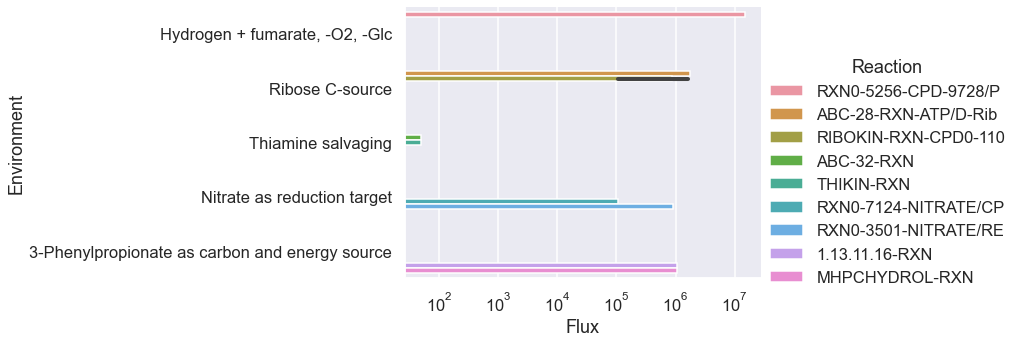

In [25]:
sns.catplot(y="Environment",hue="Reaction", x="Flux", data=results_df, kind="bar", aspect=2.5)
plt.xscale('log')
#plt.tight_layout()
plt.savefig("notebooks/fbagd/figures/rxns_light_up.png", dpi=300)

# Extract specific fluxes for balancing

In [ ]:
rxns_names = ['PGLUCISOM-RXN', '6PFRUCTPHOS-RXN', 'F16ALDOLASE-RXN', 'TRIOSEPISOMERIZATION-RXN', 
              'GAPOXNPHOSPHN-RXN', 'PHOSGLYPHOS-RXN', '3PGAREARR-RXN',
              '2PGADEHYDRAT-RXN', 'PEPDEPHOS-RXN']

In [ ]:
fluxes.sort_values(by=0, axis=1, ascending=False).T.head(10)

In [ ]:
fluxes_small = fluxes.loc[fluxes.index.isin(rxns_names), :]
fluxes_small

In [ ]:
fluxes.loc[fluxes.index.str.contains("TRIOSEPISOMERIZATION-RXN"),:]

In [ ]:
fluxes.loc[fluxes.index.str.contains("3PGAREARR-RXN"),:]

In [ ]:
fluxes.loc[fluxes.index.str.contains("PHOSGLYPHOS-RXN"),:]

In [ ]:
fluxes.loc[fluxes.index.str.contains("2TRANSKETO-RXN"),:]

In [ ]:
glucose_transport_reactions = ['TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//ALPHA-GLC-6-P/PTSH-MONOMER.52.',
                               'TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//D-glucopyranose-6-phosphate/PTSH-MONOMER.66.',
                               'TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//GLC-6-P/PTSH-MONOMER.46.',
                               'RXN0-7077-GLC/PROTON//ALPHA-GLUCOSE/PROTON.33.',
                               'RXN0-7077-GLC/PROTON//Glucopyranose/PROTON.33.',
                               'RXN0-7077-GLC/PROTON//GLC/PROTON.23.',
                               'TRANS-RXN0-574-GLC//GLC.9.',
                               'TRANS-RXN0-574-GLC//Glucopyranose.19.',
                               'TRANS-RXN-320-GLC/ATP/WATER//ALPHA-GLUCOSE/ADP/Pi/PROTON.43.',
                               'TRANS-RXN-320-GLC/ATP/WATER//GLC/ADP/Pi/PROTON.33.',
                               'TRANS-RXN-320-GLC/ATP/WATER//Glucopyranose/ADP/Pi/PROTON.43.']
